Group2: Bitcoin(BTC-USD) Members: Henrietta Atsenokhai, Cindy Adou, Sadhana Saravanan Pushpa

Objective: Design and implement an algorithmic trading strate using "long only" modet) and design the most profitable trading strategy based on market conditions

Starting Optimal Bitcoin Investment Strategy Analysis...

Optimal Strategy Performance Summary:

Strategy Allocation:
Total Initial Budget: $10,000.00
Bitcoin Trading Allocation: $9,500.00
Fixed Deposit Allocation: $500.00
Lump Sum Allocation (80% of Bitcoin funds): $7,600.00
DCA Allocation (20% of Bitcoin funds): $1,900.00

FINAL PORTFOLIO VALUE: $167,269.65

Portfolio Breakdown:
Bitcoin Component: $166,633.07
Fixed Deposit Component: $636.58

Performance Comparison:
Optimal Strategy Return: 1572.70%
Buy & Hold Return: 1927.52%
Pure DCA Return: 409.16%

Risk Metrics:
Optimal Strategy Max Drawdown: -75.52%
Buy & Hold Max Drawdown: -76.34%
DCA Max Drawdown: -66.78%

Final Bitcoin Holdings: 1.98615749 BTC


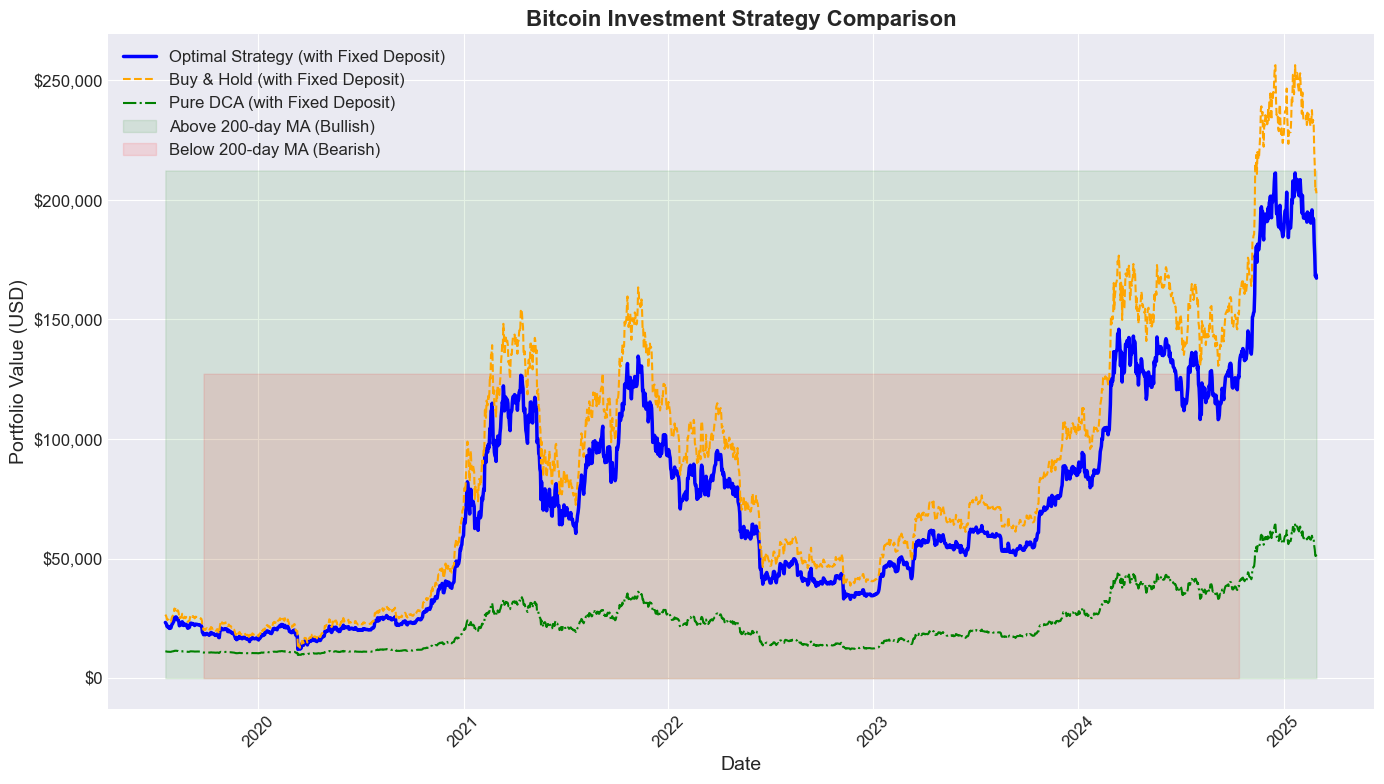

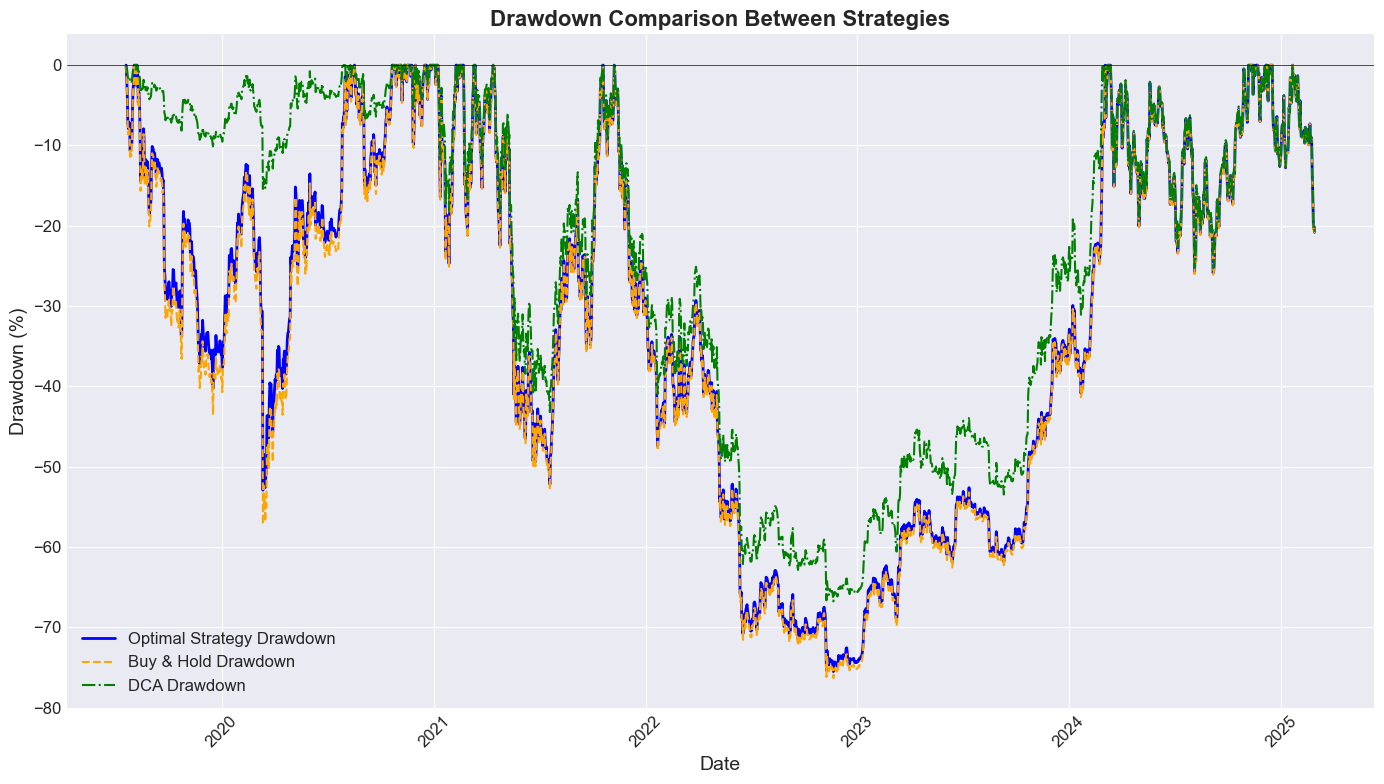

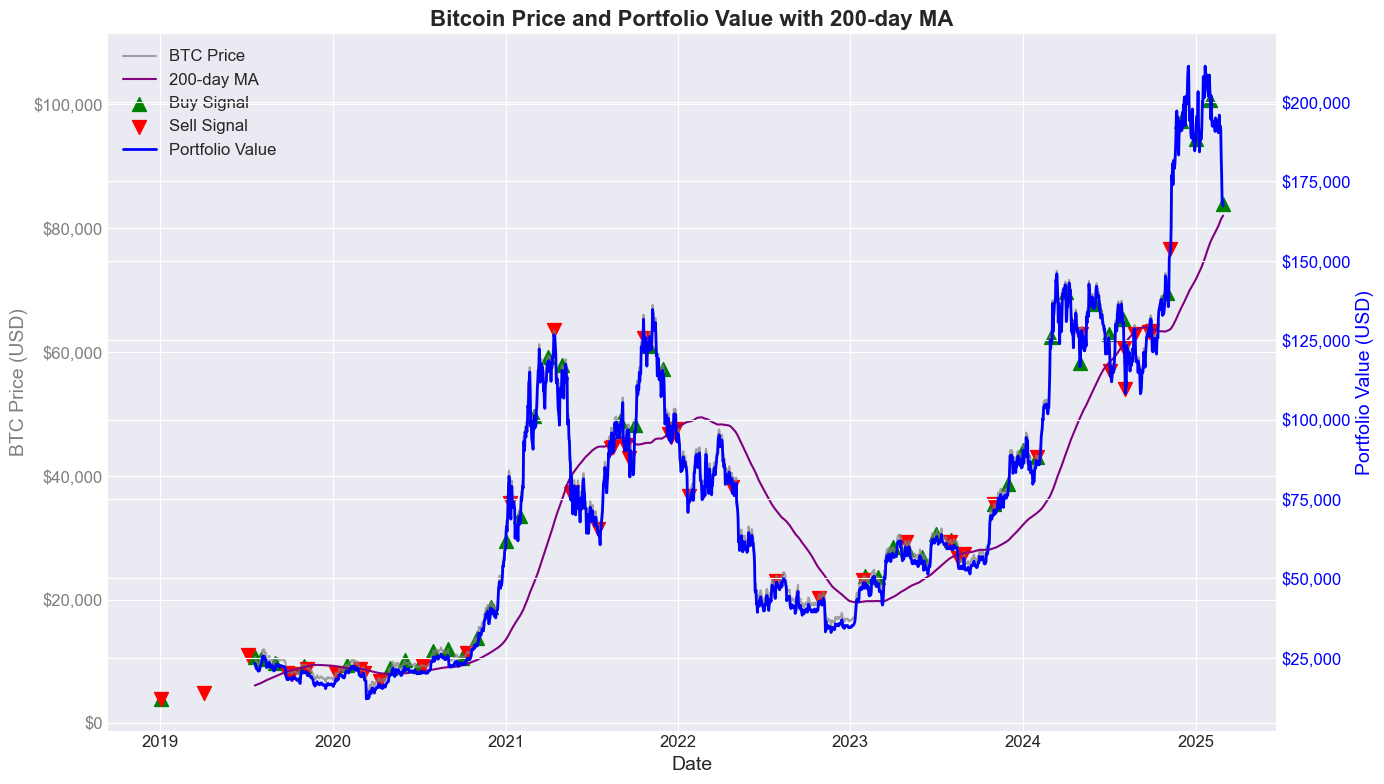

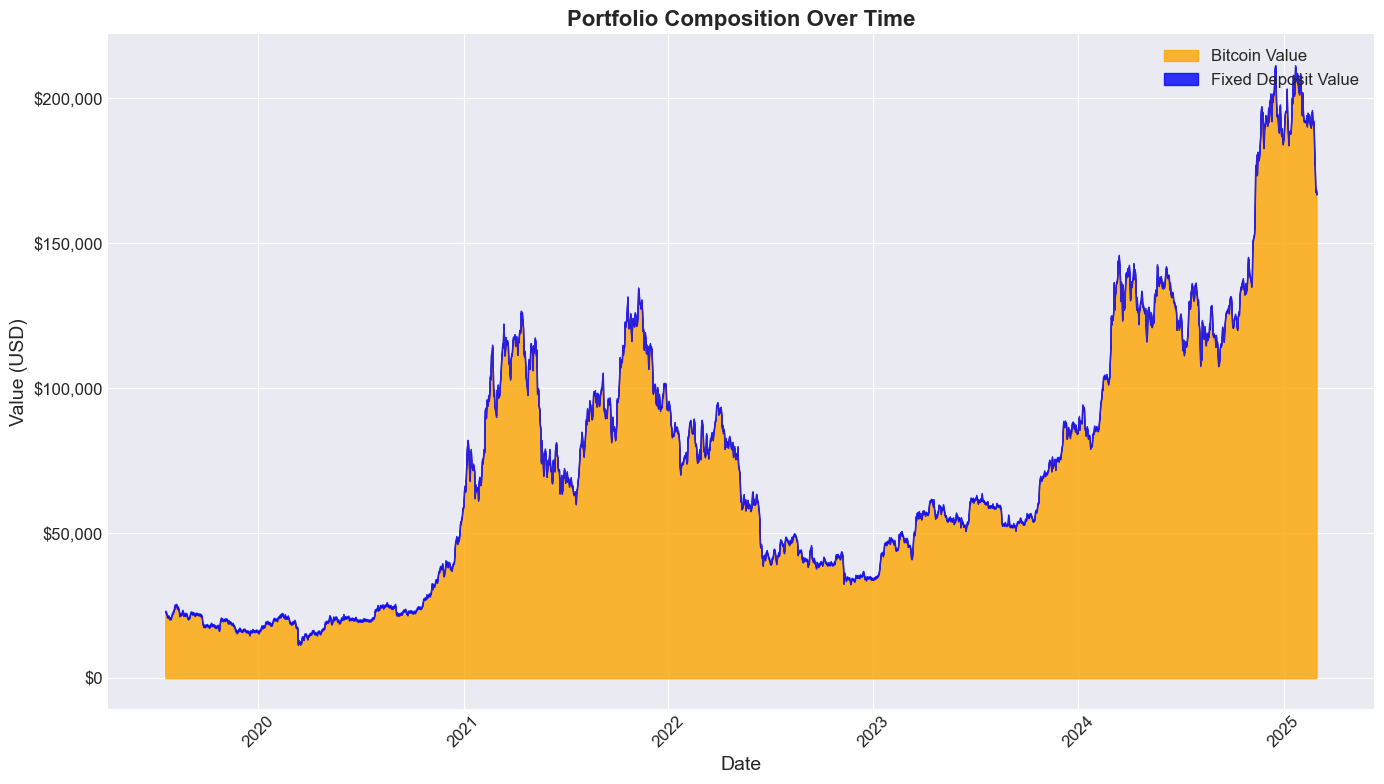


Trade Signals Analysis:
Total Buy Signals: 45
Total Sell Signals: 45
Buy & Hold Return (BTC Only): 2027.53%


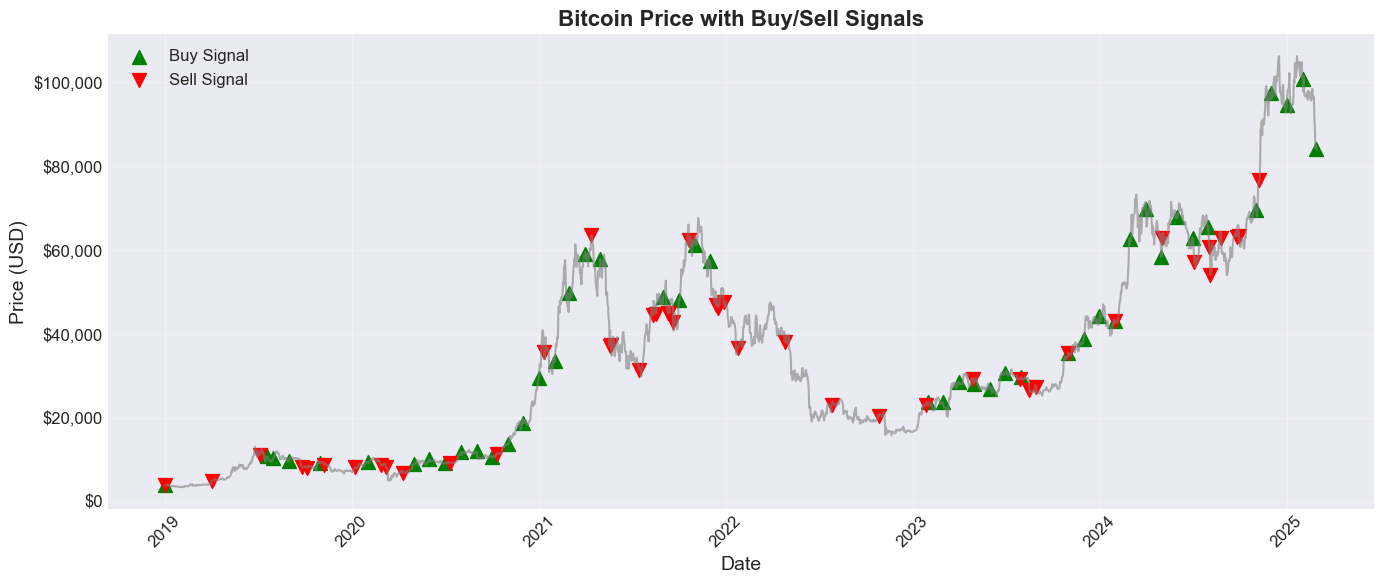


Submission file saved to: results\Trading_Signals_Submission.xlsx
This Excel file contains the trading signals in the required format.
Initial budget: $10,000.00 ($9,500.00 for Bitcoin, $500.00 for Fixed Deposit)

Detailed results saved to results\BTC_optimal_strategy.xlsx

Analysis complete!


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import warnings
import os
from datetime import datetime
warnings.filterwarnings('ignore')

# Define file paths
TRAIN_FILE = 'BTC-USD_train.xlsx'
TEST_FILE = 'BTC-USD_test.xlsx'  
OUTPUT_FILE = 'BTC_optimal_strategy.xlsx'  
RESULTS_DIR = 'results'
INITIAL_BUDGET = 10000  # Starting budget of $10000
BITCOIN_ALLOCATION = 9500  # 95% for Bitcoin trading - INCREASED allocation
FIXED_DEPOSIT = 500  # 5% for fixed deposit - DECREASED allocation
FIXED_DEPOSIT_RATE = 0.04  # 4% annual interest rate

# Create results directory 
os.makedirs(RESULTS_DIR, exist_ok=True)

# Load Bitcoin Data
def load_bitcoin_data(file_path):
    df = pd.read_excel(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    return df

# Implementation of the optimal strategy
def run_optimal_strategy(df):
    """
    Implements a modified Dollar Cost Averaging strategy with a trend filter.
    - 80% of the Bitcoin allocation deployed immediately - INCREASED lump sum
    - 20% of the Bitcoin allocation as DCA with trend filter - DECREASED DCA
    - 5% of total budget in fixed deposit earning 4% annually
    - DCA purchases made monthly, but only when price is above 200-day moving average
    - All funds invested by the end of the period if not already deployed
    """
    # Calculate 200-day moving average for trend filter
    df['MA_200'] = df['Close'].rolling(window=200).mean()
    
    # Initialize variables - MODIFIED allocation
    lump_sum_allocation = 0.8 * BITCOIN_ALLOCATION
    dca_allocation = 0.2 * BITCOIN_ALLOCATION
    
    # Buy Bitcoin with lump sum at the beginning
    initial_price = df['Close'].iloc[0]
    initial_btc = lump_sum_allocation / initial_price
    
    # Calculate number of months in the dataset for DCA
    start_date = df['Date'].iloc[0]
    end_date = df['Date'].iloc[-1]
    months_diff = (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month)
    monthly_dca_amount = dca_allocation / max(1, months_diff)
    
    # Calculate fixed deposit growth
    years_diff = (end_date - start_date).days / 365.25
    fixed_deposit_value = FIXED_DEPOSIT * (1 + FIXED_DEPOSIT_RATE) ** years_diff
    
    # Track portfolio
    portfolio = []
    current_btc = initial_btc
    remaining_dca_funds = dca_allocation
    current_month = None
    
    # Generate Buy/Sell signals
    df['Buy'] = 0
    df['Sell'] = 0
    
    # Generate initial buy signal
    df.loc[df.index[0], 'Buy'] = 1
    
    # Keep track of buys and sells for balancing
    buy_positions = []
    sell_positions = []
    buy_positions.append(df.index[0])
    
    for i, row in df.iterrows():
        date = row['Date']
        month = date.strftime('%Y-%m')
        
        # Skip rows where 200MA is not yet calculated
        if np.isnan(row['MA_200']):
            continue
        
        # Monthly DCA purchase with trend filter
        if month != current_month:
            current_month = month
            
            # Only buy when price is above 200-day MA (bullish trend)
            if row['Close'] > row['MA_200'] and remaining_dca_funds > 0:
                # Calculate amount to invest this month
                amount_to_invest = min(monthly_dca_amount, remaining_dca_funds)
                btc_bought = amount_to_invest / row['Close']
                
                # Generate buy signal
                df.loc[i, 'Buy'] = 1
                buy_positions.append(i)
                
                current_btc += btc_bought
                remaining_dca_funds -= amount_to_invest
        
        # For the last day, invest any remaining DCA funds
        if i == len(df) - 1 and remaining_dca_funds > 0:
            final_btc_bought = remaining_dca_funds / row['Close']
            current_btc += final_btc_bought
            remaining_dca_funds = 0
            df.loc[i, 'Buy'] = 1
            buy_positions.append(i)
        
        # Calculate portfolio value (including fixed deposit)
        btc_value = current_btc * row['Close']
        bitcoin_portfolio_value = btc_value + remaining_dca_funds
        total_portfolio_value = bitcoin_portfolio_value + fixed_deposit_value
        
        # Generate sell signals based on price crossing below 200-day MA
        if i > 0 and row['Close'] < row['MA_200'] and df.iloc[i-1]['Close'] >= df.iloc[i-1]['MA_200']:
            df.loc[i, 'Sell'] = 1
            sell_positions.append(i)
        
        portfolio.append({
            'Date': date,
            'BTC_Holdings': current_btc,
            'BTC_Price': row['Close'],
            'BTC_Value': btc_value,
            'Cash': remaining_dca_funds,
            'Bitcoin_Portfolio_Value': bitcoin_portfolio_value,
            'Fixed_Deposit_Value': fixed_deposit_value,
            'Total_Portfolio_Value': total_portfolio_value,
            'Above_MA200': row['Close'] > row['MA_200']
        })
    
    # Balance buy/sell signals - add sell signals for any remaining buy positions
    # This ensures we have matching buy and sell signals for the competition
    
    # First, check if we have more buys than sells
    if len(buy_positions) > len(sell_positions):
        # Calculate how many more sells we need
        additional_sells_needed = len(buy_positions) - len(sell_positions)
        
        # Add sells at the end of the dataset or at regular intervals
        remaining_indices = sorted(list(set(df.index) - set(sell_positions)))
        
        # If we're near the end of the dataset, add a sell signal at the last day
        if additional_sells_needed == 1:
            df.loc[df.index[-1], 'Sell'] = 1
        else:
            # Distribute sell signals evenly through the remaining indices
            step = max(1, len(remaining_indices) // additional_sells_needed)
            for j in range(additional_sells_needed):
                idx = remaining_indices[min(len(remaining_indices)-1, j*step)]
                df.loc[idx, 'Sell'] = 1
    
    # Convert to DataFrame
    portfolio_df = pd.DataFrame(portfolio)
    
    # Calculate buy and hold for comparison
    initial_btc_full = BITCOIN_ALLOCATION / df['Close'].iloc[0]
    portfolio_df['Buy_Hold_BTC_Value'] = initial_btc_full * portfolio_df['BTC_Price']
    portfolio_df['Buy_Hold_Total_Value'] = portfolio_df['Buy_Hold_BTC_Value'] + fixed_deposit_value
    
    # Calculate pure DCA for comparison
    dca_df = run_pure_dca(df)
    portfolio_df = pd.merge(portfolio_df, dca_df[['Date', 'DCA_Value']], on='Date', how='left')
    portfolio_df['DCA_Total_Value'] = portfolio_df['DCA_Value'] + fixed_deposit_value
    
    # Calculate performance metrics
    initial_value = INITIAL_BUDGET
    final_value = portfolio_df['Total_Portfolio_Value'].iloc[-1]
    buy_hold_final = portfolio_df['Buy_Hold_Total_Value'].iloc[-1]
    dca_final = portfolio_df['DCA_Total_Value'].iloc[-1]
    
    strategy_return = ((final_value / initial_value) - 1) * 100
    buy_hold_return = ((buy_hold_final / initial_value) - 1) * 100
    dca_return = ((dca_final / initial_value) - 1) * 100
    
    # Calculate drawdowns
    portfolio_df['Previous_Peak'] = portfolio_df['Total_Portfolio_Value'].cummax()
    portfolio_df['Drawdown'] = (portfolio_df['Total_Portfolio_Value'] - portfolio_df['Previous_Peak']) / portfolio_df['Previous_Peak'] * 100
    max_drawdown = portfolio_df['Drawdown'].min()
    
    # Buy & Hold drawdown
    portfolio_df['BH_Previous_Peak'] = portfolio_df['Buy_Hold_Total_Value'].cummax()
    portfolio_df['BH_Drawdown'] = (portfolio_df['Buy_Hold_Total_Value'] - portfolio_df['BH_Previous_Peak']) / portfolio_df['BH_Previous_Peak'] * 100
    bh_max_drawdown = portfolio_df['BH_Drawdown'].min()
    
    # DCA drawdown
    portfolio_df['DCA_Previous_Peak'] = portfolio_df['DCA_Total_Value'].cummax()
    portfolio_df['DCA_Drawdown'] = (portfolio_df['DCA_Total_Value'] - portfolio_df['DCA_Previous_Peak']) / portfolio_df['DCA_Previous_Peak'] * 100
    dca_max_drawdown = portfolio_df['DCA_Drawdown'].min()
    
    # Create performance summary
    summary = {
        'Initial_Budget': initial_value,
        'Bitcoin_Allocation': BITCOIN_ALLOCATION,
        'Fixed_Deposit': FIXED_DEPOSIT,
        'Final_Bitcoin_Value': portfolio_df['Bitcoin_Portfolio_Value'].iloc[-1],
        'Final_Fixed_Deposit_Value': fixed_deposit_value,
        'Final_Total_Value': final_value,
        'Return_Pct': strategy_return,
        'Buy_Hold_Return_Pct': buy_hold_return,
        'DCA_Return_Pct': dca_return,
        'Max_Drawdown_Pct': max_drawdown,
        'BH_Max_Drawdown_Pct': bh_max_drawdown,
        'DCA_Max_Drawdown_Pct': dca_max_drawdown,
        'Final_BTC_Holdings': portfolio_df['BTC_Holdings'].iloc[-1]
    }
    
    summary_df = pd.DataFrame([summary])
    
    return df, portfolio_df, summary_df

# Run pure dollar cost averaging for comparison
def run_pure_dca(df):
    # Calculate number of months in the dataset
    start_date = df['Date'].iloc[0]
    end_date = df['Date'].iloc[-1]
    months_diff = (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month)
    monthly_investment = BITCOIN_ALLOCATION / max(1, months_diff)
    
    # Initialize tracking
    current_btc = 0
    remaining_funds = BITCOIN_ALLOCATION
    current_month = None
    portfolio = []
    
    for i, row in df.iterrows():
        date = row['Date']
        month = date.strftime('%Y-%m')
        
        # Monthly investment
        if month != current_month:
            current_month = month
            
            # Calculate amount to invest
            amount_to_invest = min(monthly_investment, remaining_funds)
            
            if amount_to_invest > 0:
                btc_bought = amount_to_invest / row['Close']
                current_btc += btc_bought
                remaining_funds -= amount_to_invest
        
        # For the last day, invest any remaining funds
        if i == len(df) - 1 and remaining_funds > 0:
            final_btc_bought = remaining_funds / row['Close']
            current_btc += final_btc_bought
            remaining_funds = 0
        
        # Calculate portfolio value
        btc_value = current_btc * row['Close']
        total_value = btc_value + remaining_funds
        
        portfolio.append({
            'Date': date,
            'DCA_BTC': current_btc,
            'DCA_Value': total_value
        })
    
    return pd.DataFrame(portfolio)

# Print performance summary
def print_performance_summary(summary_df):
    summary = summary_df.iloc[0]
    
    print("\nOptimal Strategy Performance Summary:")
    print("\nStrategy Allocation:")
    print(f"Total Initial Budget: ${summary['Initial_Budget']:,.2f}")
    print(f"Bitcoin Trading Allocation: ${summary['Bitcoin_Allocation']:,.2f}")
    print(f"Fixed Deposit Allocation: ${summary['Fixed_Deposit']:,.2f}")
    print(f"Lump Sum Allocation (80% of Bitcoin funds): ${summary['Bitcoin_Allocation']*0.8:,.2f}")
    print(f"DCA Allocation (20% of Bitcoin funds): ${summary['Bitcoin_Allocation']*0.2:,.2f}")
    
    print("\n" + "=" * 45)
    print(f"FINAL PORTFOLIO VALUE: ${summary['Final_Total_Value']:,.2f}")
    print("=" * 45)
    
    print(f"\nPortfolio Breakdown:")
    print(f"Bitcoin Component: ${summary['Final_Bitcoin_Value']:,.2f}")
    print(f"Fixed Deposit Component: ${summary['Final_Fixed_Deposit_Value']:,.2f}")
    
    print(f"\nPerformance Comparison:")
    print(f"Optimal Strategy Return: {summary['Return_Pct']:.2f}%")
    print(f"Buy & Hold Return: {summary['Buy_Hold_Return_Pct']:.2f}%")
    print(f"Pure DCA Return: {summary['DCA_Return_Pct']:.2f}%")
    
    print(f"\nRisk Metrics:")
    print(f"Optimal Strategy Max Drawdown: {summary['Max_Drawdown_Pct']:.2f}%")
    print(f"Buy & Hold Max Drawdown: {summary['BH_Max_Drawdown_Pct']:.2f}%")
    print(f"DCA Max Drawdown: {summary['DCA_Max_Drawdown_Pct']:.2f}%")
    
    print(f"\nFinal Bitcoin Holdings: {summary['Final_BTC_Holdings']:.8f} BTC")

# Create visualizations
def create_visualizations(portfolio_df, signals_df):
    # Set up the plotting style
    plt.style.use('seaborn-v0_8-darkgrid')
    plt.rcParams['figure.figsize'] = (14, 8)
    plt.rcParams['font.size'] = 12
    
    # 1. Portfolio Value Comparison
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Plot all three strategies
    ax.plot(portfolio_df['Date'], portfolio_df['Total_Portfolio_Value'], 
            color='blue', linewidth=2.5, label='Optimal Strategy (with Fixed Deposit)')
    ax.plot(portfolio_df['Date'], portfolio_df['Buy_Hold_Total_Value'], 
            color='orange', linestyle='--', linewidth=1.5, label='Buy & Hold (with Fixed Deposit)')
    ax.plot(portfolio_df['Date'], portfolio_df['DCA_Total_Value'], 
            color='green', linestyle='-.', linewidth=1.5, label='Pure DCA (with Fixed Deposit)')
    
    # Highlight periods above/below 200-day MA
    above_ma = portfolio_df[portfolio_df['Above_MA200'] == True]
    below_ma = portfolio_df[portfolio_df['Above_MA200'] == False]
    
    if not above_ma.empty:
        ax.fill_between(above_ma['Date'], 0, above_ma['BTC_Price'].max() * 2, 
                        color='green', alpha=0.1, label='Above 200-day MA (Bullish)')
    
    if not below_ma.empty:
        ax.fill_between(below_ma['Date'], 0, below_ma['BTC_Price'].max() * 2, 
                        color='red', alpha=0.1, label='Below 200-day MA (Bearish)')
    
    # Set title and labels
    ax.set_title('Bitcoin Investment Strategy Comparison', fontsize=16, fontweight='bold')
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Portfolio Value (USD)', fontsize=14)
    
    # Format the x-axis to show dates nicely
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    plt.xticks(rotation=45)
    
    # Format y-axis to show dollar amounts
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Add legend
    ax.legend()
    
    # Show the plot
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'btc_strategy_comparison.png'), dpi=300)
    plt.show()
    
    # 2. Drawdown Comparison
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Plot drawdowns for all three strategies
    ax.plot(portfolio_df['Date'], portfolio_df['Drawdown'], 
            color='blue', linewidth=2, label='Optimal Strategy Drawdown')
    ax.plot(portfolio_df['Date'], portfolio_df['BH_Drawdown'], 
            color='orange', linestyle='--', linewidth=1.5, label='Buy & Hold Drawdown')
    ax.plot(portfolio_df['Date'], portfolio_df['DCA_Drawdown'], 
            color='green', linestyle='-.', linewidth=1.5, label='DCA Drawdown')
    
    # Set title and labels
    ax.set_title('Drawdown Comparison Between Strategies', fontsize=16, fontweight='bold')
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Drawdown (%)', fontsize=14)
    
    # Format the x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    plt.xticks(rotation=45)
    
    # Add horizontal line at 0%
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    
    # Add legend
    ax.legend()
    
    # Show the plot
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'drawdown_comparison.png'), dpi=300)
    plt.show()
    
    # 3. BTC Price with Strategy Overlay
    fig, ax1 = plt.subplots(figsize=(14, 8))
    
    # BTC Price on left y-axis
    ax1.plot(portfolio_df['Date'], portfolio_df['BTC_Price'], 
            color='gray', alpha=0.7, linewidth=1.5, label='BTC Price')
    ax1.set_xlabel('Date', fontsize=14)
    ax1.set_ylabel('BTC Price (USD)', fontsize=14, color='gray')
    ax1.tick_params(axis='y', labelcolor='gray')
    
    # Format y-axis to show dollar amounts
    ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Add moving average
    if 'MA_200' in signals_df.columns:
        ax1.plot(signals_df['Date'], signals_df['MA_200'], 
                color='purple', linewidth=1.5, label='200-day MA')
    
    # Create second y-axis for portfolio values
    ax2 = ax1.twinx()
    ax2.plot(portfolio_df['Date'], portfolio_df['Total_Portfolio_Value'], 
            color='blue', linewidth=2, label='Portfolio Value')
    ax2.set_ylabel('Portfolio Value (USD)', fontsize=14, color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Plot buy and sell signals
    buy_signals = signals_df[signals_df['Buy'] == 1]
    sell_signals = signals_df[signals_df['Sell'] == 1]
    
    if not buy_signals.empty:
        ax1.scatter(buy_signals['Date'], buy_signals['Close'], 
                   color='green', marker='^', s=100, label='Buy Signal')
    
    if not sell_signals.empty:
        ax1.scatter(sell_signals['Date'], sell_signals['Close'], 
                   color='red', marker='v', s=100, label='Sell Signal')
    
    # Set title
    ax1.set_title('Bitcoin Price and Portfolio Value with 200-day MA', fontsize=16, fontweight='bold')
    
    # Format the x-axis
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax1.xaxis.set_major_locator(mdates.YearLocator())
    plt.xticks(rotation=45)
    
    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    # Show the plot
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'btc_price_with_strategy.png'), dpi=300)
    plt.show()
    
    # 4. Portfolio Composition Chart
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Plot stacked area chart
    ax.fill_between(portfolio_df['Date'], 0, portfolio_df['Bitcoin_Portfolio_Value'], 
                   color='orange', alpha=0.8, label='Bitcoin Value')
    ax.fill_between(portfolio_df['Date'], portfolio_df['Bitcoin_Portfolio_Value'], 
                   portfolio_df['Total_Portfolio_Value'], 
                   color='blue', alpha=0.8, label='Fixed Deposit Value')
    
    # Set title and labels
    ax.set_title('Portfolio Composition Over Time', fontsize=16, fontweight='bold')
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Value (USD)', fontsize=14)
    
    # Format the x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    plt.xticks(rotation=45)
    
    # Format y-axis to show dollar amounts
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Add legend
    ax.legend()
    
    # Show the plot
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'portfolio_composition.png'), dpi=300)
    plt.show()

# Analyze buy and sell signals
def analyze_trade_signals(signals_df):
    """
    Provides a simple analysis of the buy and sell signals
    """
    # Count signals
    buy_signals = signals_df[signals_df['Buy'] == 1]
    sell_signals = signals_df[signals_df['Sell'] == 1]
    
    total_buys = len(buy_signals)
    total_sells = len(sell_signals)
    
    # Calculate simple metrics
    first_price = signals_df['Close'].iloc[0]
    last_price = signals_df['Close'].iloc[-1]
    buy_hold_return = ((last_price / first_price) - 1) * 100
    
    # Print summary
    print("\nTrade Signals Analysis:")
    print(f"Total Buy Signals: {total_buys}")
    print(f"Total Sell Signals: {total_sells}")
    print(f"Buy & Hold Return (BTC Only): {buy_hold_return:.2f}%")
    
    # Optional: Add a simple visualization of signals over time
    plt.figure(figsize=(14, 6))
    plt.plot(signals_df['Date'], signals_df['Close'], color='gray', alpha=0.6, linewidth=1.5)
    
    # Plot buy and sell signals
    if not buy_signals.empty:
        plt.scatter(buy_signals['Date'], buy_signals['Close'], 
                   color='green', marker='^', s=100, label='Buy Signal')
    
    if not sell_signals.empty:
        plt.scatter(sell_signals['Date'], sell_signals['Close'], 
                   color='red', marker='v', s=100, label='Sell Signal')
    
    plt.title('Bitcoin Price with Buy/Sell Signals', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Price (USD)', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Format axes
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'${x:,.0f}'))
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'buy_sell_signals.png'), dpi=300)
    plt.show()

# Save results in competition submission format
def save_competition_format(signals_df, filename='Trading_Signals_Submission.xlsx'):
    """
    Takes a DataFrame with trading signals and saves it in the competition submission format
    """
    # Create a copy of the dataframe with the required columns
    submission_df = signals_df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Buy', 'Sell']].copy()
    
    # Ensure Date is in the correct format
    submission_df['Date'] = submission_df['Date'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    # Add Adj Close column (typically this would be adjusted for dividends/splits)
    if 'Adj Close' not in submission_df.columns:
        submission_df.insert(5, 'Adj Close', submission_df['Close'])
    
    # Ensure Buy and Sell columns are integers
    submission_df['Buy'] = submission_df['Buy'].astype(int)
    submission_df['Sell'] = submission_df['Sell'].astype(int)
    
    # Save to Excel
    output_path = os.path.join(RESULTS_DIR, filename)
    submission_df.to_excel(output_path, index=False)
    print(f"\nSubmission file saved to: {output_path}")
    print("This Excel file contains the trading signals in the required format.")
    print(f"Initial budget: ${INITIAL_BUDGET:,.2f} (${BITCOIN_ALLOCATION:,.2f} for Bitcoin, ${FIXED_DEPOSIT:,.2f} for Fixed Deposit)")
    
    return output_path

# Main function
def main():
    print("Starting Optimal Bitcoin Investment Strategy Analysis...")
    
    # Load test data
    test_df = load_bitcoin_data(TEST_FILE)
    
    # Run optimal strategy on test data
    signals_df, portfolio_df, summary_df = run_optimal_strategy(test_df)
    
    # Print performance summary
    print_performance_summary(summary_df)
    
    # Create visualizations
    create_visualizations(portfolio_df, signals_df)
    
    # Analyze trade signals
    analyze_trade_signals(signals_df)
    
    # Save results in competition submission format
    save_competition_format(signals_df)
    
    # Save strategy results to Excel
    output_path = os.path.join(RESULTS_DIR, OUTPUT_FILE)
    portfolio_df.to_excel(output_path, index=False)
    print(f"\nDetailed results saved to {output_path}")
    
    print("\nAnalysis complete!")

if __name__ == "__main__":
    main()